# Time Series Forecasting in Stata <a class="tocSkip">

<!-- There are some fundamental concepts in macroeconomics that take the premise that interests rates and asset prices have useful information for economic developement. For instance, Stock & Watson analyze quarterly data to predict output growth and consumption. They analyze on as many as 43 variables from each of seven developed economies (Canada, France, Germany, Italy, Japan, the United Kingdom, and the United States) over 1959-99. Most of these predictors are asset prices, but they also consider measures of real economic activity, wages, prices, and money supply. -->

This post aims to give a beginner's introduction to time series forecasting using Stata. Even though, programming languages like R and Python are very powerfull to manage data and make forecasts, Stata is still one of the most popular options among economists.

In this post, I want to show how Jupyter Notebooks can be used to present results and statistical models in Stata. I will use the [`stata_kernel`](https://kylebarron.dev/stata_kernel/) and show that Stata + Jupyter Notebooks are a great option when you want to estimate econometric models.

For the forecast, I will use the oil price to predict consumption in USA. I use the data and models from Stock & Watson (2003): "Forecasting Output and Inflation: The Role of Asset Prices". Additionally, if you want to replicate the results, you can go to the GitHub repository.

<!-- After completing this post, you will know:
- How to forecast with ARDL models 
- How to obtain the best statistical model -->

## Data

As I mentioned previously, I will use the data from Stock & Watson (2003). To keep it short, I will focus on forecasting consumption using oil price. The data goes from the 1st quarter of 1959 to the last quarter of 1999. The variable names are:
- **cpi**: represents the Consumer Price Index.
- **oil**: represents a standardized price of Oil.

First, I will read the data. Then, I will create the variable **time**, and finally using `%tail 5` I will show you the last 5 rows of the dataset.

In [1]:
use data_forecast_us, clear

generate time = q(1959q1) + _n-1
format time %tq
tsset time





        time variable:  time, 1959q1 to 1999q4
                delta:  1 quarter


In [2]:
%tail 5

,rovnght,exrate,oil,cpi,rgdp,time
160,4.68,114.72,10.41,164.17,110.58,1998q4
161,4.81,118.05,12.86,164.87,111.58,1999q1
162,4.76,119.47,16.24,166.2,112.1,1999q2
163,5.22,114.79,22.41,167.23,113.65,1999q3
164,5.3,114.68,24.97,168.43,115.67,1999q4


In order to predict consumption, I will calculate the inflation following Stock & Watson (2003). I consider: $Y_{t+1} = 400\log(P_{t+1}/P_t) - 400\log(P_t/P_{t-1})$. And in the case of oil: $Y_{t+1} = 400\log(O_{t+1}/O_t)$.

In [3]:
quietly gen doil = 400 * ln(oil/l.oil)
quietly gen infl = 400 * ln(cpi/l.cpi) - 400 * ln(l.cpi/l2.cpi)

## ARDL Model

For the forecast, I will use an [ARDL](https://www.stata.com/meeting/chicago16/slides/chicago16_kripfganz.pdf) model. This model is very easy to implement in Stata. I will focus in the time frame of 1985 - 1999. If you don't have installed the `ardl` command, firt you need to run: `net install ardl, from(http://www.kripfganz.de/stata/)`.

Specifically, I will estimate a model to forecast inflation using lagged inflation and lagged oil price.

In [4]:
ardl infl doil if time < tq(1985q1), lags(1) fast


ARDL(1,1) regression

Sample: 1959q4 - 1984q4                         Number of obs     =        101
                                                F(   3,     97)   =       4.19
                                                Prob > F          =     0.0078
                                                R-squared         =     0.1147
                                                Adj R-squared     =     0.0873
Log likelihood = -197.18579                     Root MSE          =     1.7395

------------------------------------------------------------------------------
        infl |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        infl |
         L1. |  -.2343423   .0990587    -2.37   0.020    -.4309464   -.0377383
             |
        doil |
         --. |    .007935   .0028173     2.82   0.006     .0023434    .0135266
         L1. |  -.0000824   .0028883    -0.03   0.977    -.005

In [5]:
estat ic


Akaike's information criterion and Bayesian information criterion

-----------------------------------------------------------------------------
       Model |        Obs  ll(null)  ll(model)      df         AIC        BIC
-------------+---------------------------------------------------------------
           . |        101  -203.338  -197.1858       4    402.3716   412.8321
-----------------------------------------------------------------------------
               Note: N=Obs used in calculating BIC; see [R] BIC note.


## Forecast

Then, I will estimate the forecast 4-steps ahead.

In [6]:
local start = tq(1984q1)
local end = tq(1998q1)
qui gen forecast = .

forvalues itime = `start'/`end' {
    eststo clear
    qui ardl infl doil if time < `itime', lags(1) fast
    qui predict pred, xb   // forecast for the next period
    qui replace forecast = pred if time == `itime' + 4
    drop pred
}

Then, let's calculate the RMSE to evaluate our results.

In [7]:
qui gen resid2 = (forecast - infl)^2 if (time >= `start' + 4) & (time <= `end' + 4)
qui sum resid2
gen mresid2 = r(mean)
scalar mresid_doil = sqrt(mresid2)
display "MRSE = " mresid_doil






MRSE = 1.2321423


And finally, let's plot our prediction with the actual data.

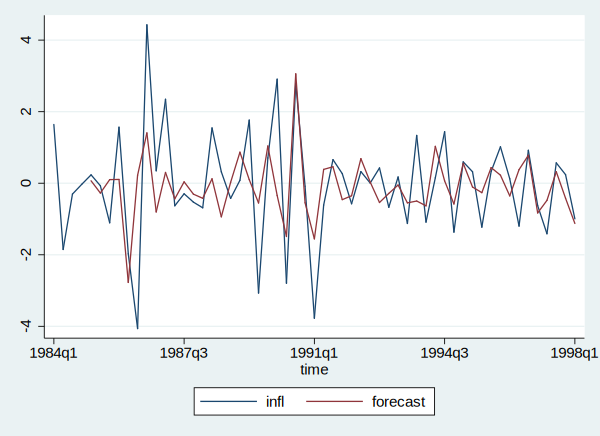

In [8]:
tsline infl forecast if (time >= `start') & (time <= `end')

As you can see, using Stata inside Jupyter Notebooks brings useful ways to present your data and results. Since I have omitted a lot of details about the estimation procedure, you can read more about forecasting and Stata here:
- [How to install Stata kernel](https://kylebarron.dev/stata_kernel/getting_started/)
- [Time Series forecasting with Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [Stata module to estimate ARDL models](https://www.stata.com/meeting/chicago16/slides/chicago16_kripfganz.pdf)